In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.ndimage import convolve1d

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier # Corrected import
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
import joblib
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv",
                     sep='|',
                     on_bad_lines='skip',
                     header=None # Add this line to indicate no header row
                    )
print("Dataset loaded successfully.")

# Assign column names based on the dataset's documentation
df.columns = [
        'ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p',
        'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state',
        'local_orig', 'local_resp', 'missed_bytes', 'history', 'orig_pkts',
        'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents', 'label',
        'detailed-label'
    ]

Dataset loaded successfully.


/tmp/ipython-input-1416481273.py:1: DtypeWarning: Columns (0,3,5,14,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv",


In [ ]:
df.shape

(257864, 23)

In [ ]:
print(df.columns.tolist())

['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents', 'label', 'detailed-label']


In [ ]:
print(df['tunnel_parents'].unique())


['tunnel_parents' '-' nan]


In [ ]:
print("\n--- Cleaning Data ---")
# Replace placeholder '-' with 0 for simplicity.
df.replace('-', 0, inplace=True)

# Convert relevant columns to numeric types, coercing errors
numerical_cols = ['duration', 'orig_bytes', 'resp_bytes', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'id.orig_p', 'id.resp_p']
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill any remaining NaN values with 0
df.fillna(0, inplace=True)
print("Data cleaning complete.")


--- Cleaning Data ---
Data cleaning complete.


In [ ]:
print("\n--- Encoding Categorical Features ---")
categorical_cols = ['proto', 'service', 'conn_state', 'history']
df_encoded = pd.get_dummies(df, columns=categorical_cols, prefix=categorical_cols)
print("One-hot encoding complete.")


--- Encoding Categorical Features ---
One-hot encoding complete.


In [ ]:
print(df_encoded.columns.tolist())

['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'duration', 'orig_bytes', 'resp_bytes', 'local_orig', 'local_resp', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents', 'label', 'detailed-label', 'proto_0', 'proto_icmp', 'proto_proto', 'proto_tcp', 'proto_udp', 'service_0', 'service_http', 'service_service', 'conn_state_0', 'conn_state_OTH', 'conn_state_REJ', 'conn_state_RSTO', 'conn_state_RSTOS0', 'conn_state_RSTR', 'conn_state_RSTRH', 'conn_state_S0', 'conn_state_S1', 'conn_state_S2', 'conn_state_SF', 'conn_state_conn_state', 'history_0', 'history_D', 'history_D^', 'history_Dd', 'history_R', 'history_S', 'history_SaR', 'history_ShA', 'history_ShADF', 'history_ShADFadfRR', 'history_ShADFr', 'history_ShADaF', 'history_ShADadR', 'history_ShADadRf', 'history_ShADadfF', 'history_ShADadfR', 'history_ShADafF', 'history_ShADafr', 'history_ShADarfF', 'history_ShADdafR', 'history_ShADdfFa', 'history_ShADr', 'history_ShADrfR', 'history_

In [ ]:
# Goal: Have a clean, fully numerical feature matrix `X` and a target vector `y`
# Separate features (X) and target (y)

# Filter out rows where 'label' is not 'Benign' or 'Malicious'
df_filtered = df_encoded[df_encoded['label'].isin(['Benign', 'Malicious'])].copy()

X = df_filtered.drop(columns=['ts', 'uid', 'id.orig_h', 'id.resp_h', 'label', 'detailed-label','tunnel_parents','id.orig_p', 'id.resp_p'])
# Extract the target variable 'label' as a pandas Series
y_text = df_filtered['label']
le = LabelEncoder()
y = le.fit_transform(y_text)

In [ ]:
print(X.columns.tolist())

['duration', 'orig_bytes', 'resp_bytes', 'local_orig', 'local_resp', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'proto_0', 'proto_icmp', 'proto_proto', 'proto_tcp', 'proto_udp', 'service_0', 'service_http', 'service_service', 'conn_state_0', 'conn_state_OTH', 'conn_state_REJ', 'conn_state_RSTO', 'conn_state_RSTOS0', 'conn_state_RSTR', 'conn_state_RSTRH', 'conn_state_S0', 'conn_state_S1', 'conn_state_S2', 'conn_state_SF', 'conn_state_conn_state', 'history_0', 'history_D', 'history_D^', 'history_Dd', 'history_R', 'history_S', 'history_SaR', 'history_ShA', 'history_ShADF', 'history_ShADFadfRR', 'history_ShADFr', 'history_ShADaF', 'history_ShADadR', 'history_ShADadRf', 'history_ShADadfF', 'history_ShADadfR', 'history_ShADafF', 'history_ShADafr', 'history_ShADarfF', 'history_ShADdafR', 'history_ShADdfFa', 'history_ShADr', 'history_ShADrfR', 'history_ShAF', 'history_ShAFa', 'history_ShAFf', 'history_ShAFr', 'history_ShAdDaF', 'history_ShAdDaFRf', 'history_ShA

In [ ]:
print("--- Starting Feature Engineering Steps ---")

# --- Step 2: Isolate Numerical Features & Create the 1D-Gaussian Filter ---

# Action: Isolate the original numerical feature columns from the full feature matrix 'X'
# These are the columns that existed before one-hot encoding.
original_numerical_cols = ['duration', 'orig_bytes', 'resp_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes']

# Ensure only columns that actually exist in X are selected
existing_numerical_cols = [col for col in original_numerical_cols if col in X.columns]
X_numerical = X[existing_numerical_cols]
print(f"Isolated numerical features. Shape: {X_numerical.shape}")


--- Starting Feature Engineering Steps ---
Isolated numerical features. Shape: (257862, 7)


In [ ]:
# Action: Define the 1D-Gaussian filter kernel from the paper
gaussian_filter = np.array([1, 4, 7, 4, 1])
print(f"\nDefined 1D-Gaussian filter: {gaussian_filter}")


Defined 1D-Gaussian filter: [1 4 7 4 1]


In [ ]:
X_masked = convolve1d(X_numerical.values, weights=gaussian_filter, axis=1, mode='constant', cval=0.0)
print("\nApplied filter to numerical data to create masked features.")


Applied filter to numerical data to create masked features.


In [ ]:
masked_feature_names = [f"{col}_masked" for col in existing_numerical_cols]
X_masked_df = pd.DataFrame(X_masked, index=X.index, columns=masked_feature_names)

In [ ]:
X_combined = pd.concat([X, X_masked_df], axis=1)
print("\nCombined original and masked features.")


Combined original and masked features.


In [ ]:
print(X_combined.columns.to_list())

['duration', 'orig_bytes', 'resp_bytes', 'local_orig', 'local_resp', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'proto_0', 'proto_icmp', 'proto_proto', 'proto_tcp', 'proto_udp', 'service_0', 'service_http', 'service_service', 'conn_state_0', 'conn_state_OTH', 'conn_state_REJ', 'conn_state_RSTO', 'conn_state_RSTOS0', 'conn_state_RSTR', 'conn_state_RSTRH', 'conn_state_S0', 'conn_state_S1', 'conn_state_S2', 'conn_state_SF', 'conn_state_conn_state', 'history_0', 'history_D', 'history_D^', 'history_Dd', 'history_R', 'history_S', 'history_SaR', 'history_ShA', 'history_ShADF', 'history_ShADFadfRR', 'history_ShADFr', 'history_ShADaF', 'history_ShADadR', 'history_ShADadRf', 'history_ShADadfF', 'history_ShADadfR', 'history_ShADafF', 'history_ShADafr', 'history_ShADarfF', 'history_ShADdafR', 'history_ShADdfFa', 'history_ShADr', 'history_ShADrfR', 'history_ShAF', 'history_ShAFa', 'history_ShAFf', 'history_ShAFr', 'history_ShAdDaF', 'history_ShAdDaFRf', 'history_ShA

In [ ]:
#---- training and testing-------

In [ ]:
X_train_comb, X_test_comb, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
dt_classifier_comb = DecisionTreeClassifier(random_state=42)
dt_classifier_comb.fit(X_train_comb, y_train)
print("Decision Tree model trained.")

Decision Tree model trained.


In [ ]:
# Action: Evaluate the model
y_pred_comb = dt_classifier_comb.predict(X_test_comb)
print("\n--- Evaluation for Model with Combined Features ---")
accuracy_comb = accuracy_score(y_test, y_pred_comb)
print(f"Accuracy: {accuracy_comb:.4f}")
print("\nClassification Report:")
report_comb = classification_report(y_test, y_pred_comb, target_names=['Benign', 'Malicious'])
print(report_comb)


--- Evaluation for Model with Combined Features ---
Accuracy: 0.9543

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.90      0.95     35281
   Malicious       0.92      1.00      0.96     42078

    accuracy                           0.95     77359
   macro avg       0.96      0.95      0.95     77359
weighted avg       0.96      0.95      0.95     77359




Displaying Confusion Matrix...


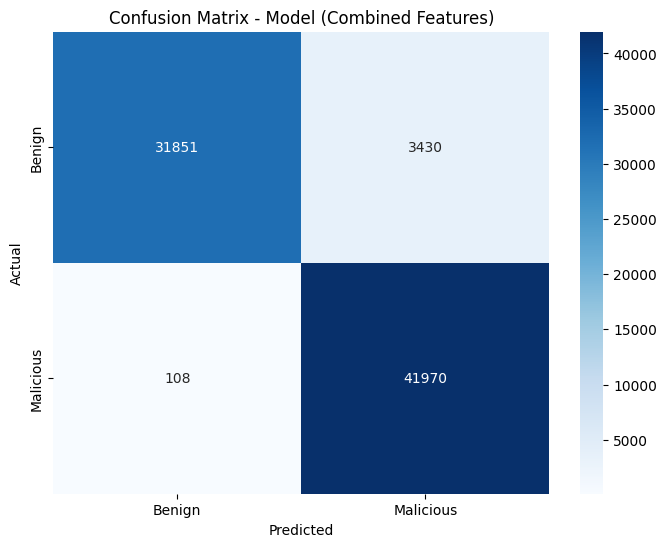

In [ ]:
print("\nDisplaying Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred_comb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.title('Confusion Matrix - Model (Combined Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
model_filename = 'decision_tree_model.joblib'
joblib.dump(dt_classifier_comb, model_filename)
joblib.dump(X_combined.columns, 'model_columns.joblib')
print(f"Model saved to {model_filename}")

Model saved to decision_tree_model.joblib


In [ ]:
# # Random Forest instead of Decision Tree
# rf_classifier_comb = RandomForestClassifier(
#     n_estimators=100,        # number of trees in the forest (default=100)
#     random_state=42,
#     n_jobs=-1                # use all CPU cores for speed
# )

# # Train the model
# rf_classifier_comb.fit(X_train_comb, y_train)

# print("Random Forest model trained.")

In [ ]:
# # Action: Evaluate the model
# y_pred_comb = rf_classifier_comb.predict(X_test_comb)
# print("\n--- Evaluation for Model with Combined Features ---")
# accuracy_comb = accuracy_score(y_test, y_pred_comb)
# print(f"Accuracy: {accuracy_comb:.4f}")
# print("\nClassification Report:")
# report_comb = classification_report(y_test, y_pred_comb, target_names=['Benign', 'Malicious'])
# print(report_comb)

In [ ]:
# print("\nDisplaying Confusion Matrix...")
# cm = confusion_matrix(y_test, y_pred_comb)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
# plt.title('Confusion Matrix - Model (Combined Features)')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

In [ ]:
# print("\n--- Evaluating Original Models with 5-Fold Cross-Validation ---")

# # Original Decision Tree
# dt_original = DecisionTreeClassifier(random_state=42)
# cv_scores_dt = cross_val_score(dt_original, X_combined, y, cv=5)
# print(f"Original Decision Tree CV Accuracy Scores: {cv_scores_dt}")
# print(f"Original Decision Tree CV Average Accuracy: {np.mean(cv_scores_dt):.4f}")

# # Original Random Forest
# rf_original = RandomForestClassifier(random_state=42, n_jobs=-1)
# cv_scores_rf = cross_val_score(rf_original, X_combined, y, cv=5)
# print(f"\nOriginal Random Forest CV Accuracy Scores: {cv_scores_rf}")
# print(f"Original Random Forest CV Average Accuracy: {np.mean(cv_scores_rf):.4f}")




In [ ]:
# print("\n\n--- Training and Evaluating a PRUNED Decision Tree ---")
# # We create a new Decision Tree with max_depth=10.
# # This prevents the tree from becoming too complex and overfitting.
# dt_pruned = DecisionTreeClassifier(max_depth=10, random_state=42)

# # Evaluate the pruned model using 5-fold cross-validation
# cv_scores_pruned = cross_val_score(dt_pruned, X_combined, y, cv=5)

# print(f"PRUNED Decision Tree CV Accuracy Scores: {cv_scores_pruned}")
# print(f"PRUNED Decision Tree CV Average Accuracy: {np.mean(cv_scores_pruned):.4f}")

# print("\n--- Analysis ---")
# print("The cross-validation scores for the pruned model are likely slightly lower,")
# print("but they represent a more realistic and reliable measure of the model's performance on new, unseen data.")

# # You can now choose to save this more robust, pruned model
# dt_pruned.fit(X_combined, y) # Train it on all data before saving


In [ ]:
# y_pred_pruned = dt_pruned.predict(X_test_comb)

In [ ]:
# cm_pruned = confusion_matrix(y_test, y_pred_pruned)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm_pruned, annot=True, fmt='d', cmap='Greens', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
# plt.title('Confusion Matrix - Pruned Model (max_depth=10)')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()